In [1]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/train"
val_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/val"
test_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/test"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 51328 images belonging to 7 classes.
Found 10999 images belonging to 7 classes.
Found 10999 images belonging to 7 classes.


In [2]:
from keras.applications import ResNet50V2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam, RMSprop

base_model = ResNet50V2(weights=None,
                      input_shape = (224,224,3),
                      include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(256, activation="relu")(x)  
x = Dropout(0.5)(x)  
predictions = Dense(7, activation="softmax")(x)  


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer= Adam(learning_rate=2e-5),loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = "saved_models/resnet50v2_best_model.hdf5"
checkpoint_cb = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True,monitor='val_loss')
early_stop_cb = EarlyStopping(patience=15,restore_best_weights=True)

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint_cb,early_stop_cb])

Epoch 1/300
1604/1604 [==============================] - ETA: 0s - loss: 1.8900 - accuracy: 0.2117
Epoch 1: val_loss improved from inf to 1.81390, saving model to saved_models\resnet50v2_best_model.hdf5
1604/1604 [==============================] - 395s 240ms/step - loss: 1.8900 - accuracy: 0.2117 - val_loss: 1.8139 - val_accuracy: 0.2709
Epoch 2/300
1604/1604 [==============================] - ETA: 0s - loss: 1.5983 - accuracy: 0.3659
Epoch 2: val_loss improved from 1.81390 to 1.47748, saving model to saved_models\resnet50v2_best_model.hdf5
1604/1604 [==============================] - 403s 251ms/step - loss: 1.5983 - accuracy: 0.3659 - val_loss: 1.4775 - val_accuracy: 0.4251
Epoch 3/300
1604/1604 [==============================] - ETA: 0s - loss: 1.3765 - accuracy: 0.4775
Epoch 3: val_loss did not improve from 1.47748
1604/1604 [==============================] - 401s 250ms/step - loss: 1.3765 - accuracy: 0.4775 - val_loss: 1.5237 - val_accuracy: 0.4183
Epoch 4/300
1604/1604 [==========

In [8]:
model.evaluate(test_generator)


344/344 [==============================] - 23s 66ms/step - loss: 1.1616 - accuracy: 0.5598


[1.1615817546844482, 0.5597781538963318]

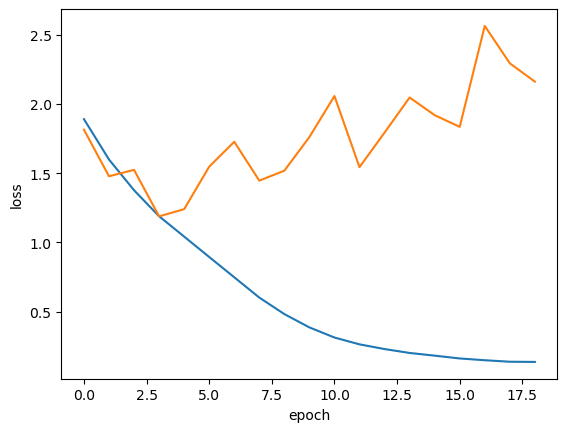

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

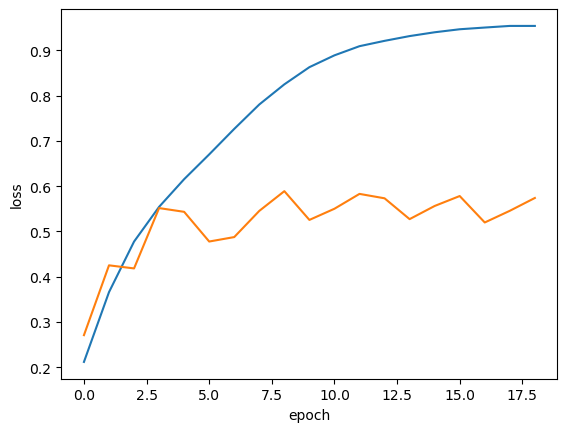

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()